Seattle has a reputation for being a pet friendly city. By some estimates, there are more dogs in the city than there are children, an impressive feat for a place as populous as Seattle. [Seattle's open data portal](https://data.seattle.gov/) contains, among other things, information on [licensed pets](https://data.seattle.gov/Community/Seattle-Pet-Licenses/jguv-t9rb).
 
Awesome!

Let's explore the kinds of insights that can be found by looking at this data.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn_wordcloud import venn2_wordcloud

%matplotlib inline

In [2]:
license_file = "pet_licenses.csv"
# Alternatively, the license file may be read from here
# license_file = "https://data.seattle.gov/api/views/jguv-t9rb/rows.csv?accessType=DOWNLOAD"

pets = pd.read_csv(license_file)

## Cleaning the data
Let's inspect the dataset to ensure it's properly cleaned before any analysis is run on it.

First, what does our data look like?

In [3]:
pets.shape  # (rows, columns)

(53663, 7)

In [4]:
pets.columns

Index(['License Issue Date', 'License Number', 'Animal's Name', 'Species',
       'Primary Breed', 'Secondary Breed', 'ZIP Code'],
      dtype='object')

Let's rename the columns so they're easier to work with

In [5]:
pets.columns = [
    "license_issued", "license", "name",
    "species", "primary_breed",
    "secondary_breed", "zipcode",
]

Let's also make sure that we use the first 5 digits in a zipcode

In [30]:
pets.zipcode.str.extract("\d\d\d")

/home/bkindle/.virtualenvs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


ValueError: pattern contains no capture groups

In [6]:
# how many NaNs does each colum have?
# https://stackoverflow.com/a/26266451
pets.isna().sum()

license_issued         0
license                0
name                 709
species                0
primary_breed          0
secondary_breed    32083
zipcode              361
dtype: int64

Given the amount of `NaN` values in the `secondary_breed` column, most owners either don't know what breed their pet is mixed with, or left that section blank when applying for a license.

A fair number of licenses also don't have the `name` listed. It's possible these animals were either babies or recently adopted at the time of their licensing.

![cute beagle puppy](https://images.pexels.com/photos/460823/pexels-photo-460823.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)
Cute!

In either case, let's replace the missing values from `secondary_breed` and drop the rest of the `NaN`s

In [7]:
pets = (pets
    .fillna({"secondary_breed": ""})
    .dropna()
)

pets.describe()

,license_issued,license,name,species,primary_breed,secondary_breed,zipcode
count,52596,52596,52596,52596,52596,52596,52596
unique,1061,52570,14006,4,335,256,154
top,January 16 2018,133239,Lucy,Dog,Domestic Shorthair,,98115
freq,448,3,457,35278,9976,31570,4851


`license_issued` looks like it's a string - it would be more useful as a datetime object

In [8]:
pets["license_issued"] = pd.to_datetime(pets["license_issued"])

There are also duplicate licenses that we should get rid of

In [9]:
pets.drop_duplicates(subset=["license"], inplace=True)

Our data should be clean enough now, let's move on to the analysis.

## Cats & Dogs
Almost all licenses are for either cats or dogs.

![cat and dog together](https://images.pexels.com/photos/46024/pexels-photo-46024.jpeg?auto=compress&cs=tinysrgb&h=750&w=1260)

In [10]:
pets.groupby("species").species.count().sort_values(ascending=False)

species
Dog     35260
Cat     17268
Goat       38
Pig         4
Name: species, dtype: int64

In [11]:
cats = pets[pets.species == "Cat"]
dogs = pets[pets.species == "Dog"]

### Most common names

In [12]:
cat_names = cats.name.value_counts()
dog_names = dogs.name.value_counts()

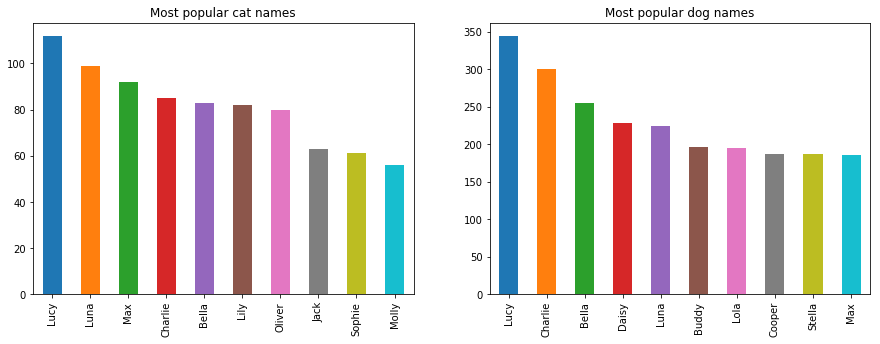

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

cat_names.head(10).plot.bar(
    title="Most popular cat names",
    ax=ax[0],
)

dog_names.head(10).plot.bar(
    title="Most popular dog names",
    ax=ax[1],
)

plt.show()

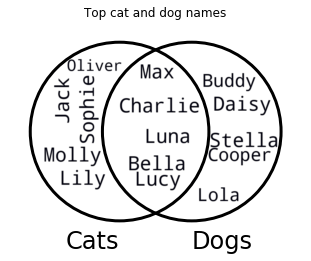

In [14]:
fig, ax = plt.subplots(1, 1)

ax.set_title("Top cat and dog names")
venn2_wordcloud(
    [
        set(cat_names.head(10).index),
        set(dog_names.head(10).index),
    ],
    set_labels=("Cats", "Dogs"),
    ax=ax,
)

plt.show()

**Conclusion**: if you're ever on the street and bump into a dog (or cat!), your best bet is to call it Lucy.

### Breed
Which breeds are the most common?

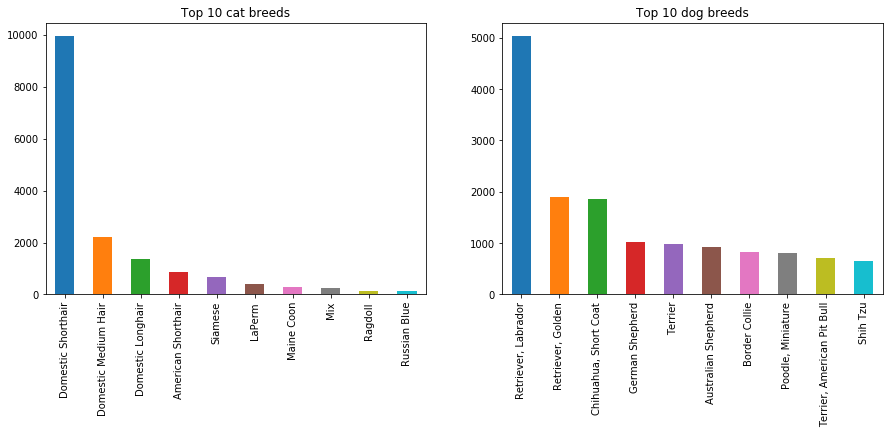

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

cats.primary_breed.value_counts().head(10).plot.bar(title="Top 10 cat breeds", ax=ax[0])
dogs.primary_breed.value_counts().head(10).plot.bar(title="Top 10 dog breeds", ax=ax[1])

We've all heard of the cliché of getting your loved ones a pet for Valentine's day, but apparently February is the least popular month to license a pet.

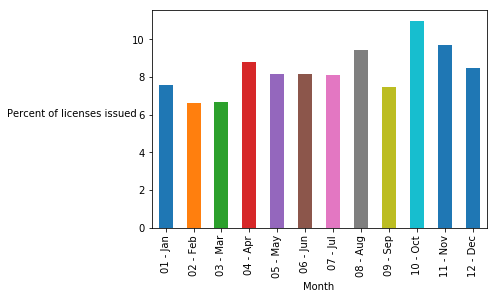

In [16]:
ax = (pets
 .license_issued
 .apply(lambda date: date.strftime("%m - %b"))
 .value_counts(normalize=True).apply(lambda percent: percent * 100)
 .sort_index()
 .plot.bar()
)

ax.set_ylabel("Percent of licenses issued", rotation=0, labelpad=60)
ax.set_xlabel("Month")

ax

## Where are the pets?
Are there specific places within Seattle that have more pets than others?

In [28]:
pets.zipcode.str.extract(r"()")

0        98116
1        98126
2        98103
3        98118
5        98117
6        98112
7        98118
8        98118
9        98199
10       98125
11       98125
12       98121
13       98105
14       98117
15       98118
16       98105
17       98109
18       98115
19       98126
20       98115
21       98118
22       98117
23       98199
24       98115
25       98103
26       98112
27       98103
28       98103
29            
30       98117
         ...  
53633    98106
53634    98118
53635    98103
53636    98107
53637    98118
53638    98144
53639    98122
53640    98133
53641    98116
53642    98103
53643    98117
53644    98103
53645    98115
53646    98115
53647    98144
53648    98199
53649    98102
53650    98104
53651    98106
53652    98146
53653    98105
53654    98117
53655    98117
53656    98144
53657    98117
53658    98122
53659    98109
53660    98122
53661    98199
53662    98116
Name: zipcode, Length: 52570, dtype: object

In [27]:
# pets.zipcode.apply(lambda zipcode: zipcode.split("-")[0]).unique()
pets[pets.zipcode.str.match("^[0-9][0-9][0-9][0-9][0-9]")].zipcode

0        98116
1        98126
2        98103
3        98118
5        98117
6        98112
7        98118
8        98118
9        98199
10       98125
11       98125
12       98121
13       98105
14       98117
15       98118
16       98105
17       98109
18       98115
19       98126
20       98115
21       98118
22       98117
23       98199
24       98115
25       98103
26       98112
27       98103
28       98103
30       98117
31       98125
         ...  
53633    98106
53634    98118
53635    98103
53636    98107
53637    98118
53638    98144
53639    98122
53640    98133
53641    98116
53642    98103
53643    98117
53644    98103
53645    98115
53646    98115
53647    98144
53648    98199
53649    98102
53650    98104
53651    98106
53652    98146
53653    98105
53654    98117
53655    98117
53656    98144
53657    98117
53658    98122
53659    98109
53660    98122
53661    98199
53662    98116
Name: zipcode, Length: 52500, dtype: object

In [13]:
import folium
import requests

SEATTLE_COORDINATES = (47.63, -122.27)
DEFAULT_ZOOM = 10
# Thank you, SeattleIO, for providing this!
ZIPCODE_GEO_URL = (
    "https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/master/data/zip-codes.geojson"
)
ZIPCODE_GEO_TEXT = requests.get(ZIPCODE_GEO_URL).text

def plot_data_by_zipcode(data,
                         location=SEATTLE_COORDINATES,
                         zoom_start=DEFAULT_ZOOM,
                         geo_data=ZIPCODE_GEO_TEXT, 
                         key_on="feature.properties.ZCTA5CE10",
                         fill_color="PuBuGn",
                         **kwargs):
    """Plot data on a choropleth map
    
    With the exception of map_coordinates and default_zoom, all arguments
    in this function are passed to folium.Map.choropleth. map_coordinates
    and default_zoom arguments are passed in as parameters to the folium.Map
    constructor.
    
    Args:
        data - data to pass into the choropleth map. Corresponds to the
               data argument passed into folium.Map.choropleth and is usually
               a pandas DataFrame or Series.
        **kwargs - Additional arguments to pass to folium.Map.choropleth
        
    Returns:
        A folium.Map instance containing a choropleth of mapped data
    """    
    map_ = folium.Map(location=location, zoom_start=zoom_start)

    map_.choropleth(
        geo_data=geo_data,
        data=data,
        key_on=key_on,
        fill_color=fill_color,
        **kwargs,
    )
    
    return map_

In [14]:
corgi_count_by_zipcode = corgis.groupby("ZIP Code")["ZIP Code"].count().sort_values(ascending=False)

plot_data_by_zipcode(data=corgi_count_by_zipcode, legend_name="Seattle Corgi Population by Zipcode")

# Is that any different than the distribution of all dogs?

In [20]:
dogs_by_zipcode = dogs.groupby("ZIP Code")["ZIP Code"].count().sort_values(ascending=False)

plot_data_by_zipcode(dogs_by_zipcode, legend_name="Dog Count by Zipcode")

# Where do the cool cats live?

In [16]:
cats = pets[pets.Species == "Cat"]

cats_by_zipcode = cats.groupby("ZIP Code")["ZIP Code"].count()

plot_data_by_zipcode(data=cats_by_zipcode, legend_name="Cat Count by Zipcode")

# Conclusion - go to Green Lake